# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

Признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

Целевой признак:
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Загрузим все необходимые нам библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

Загрузим все 3 файла и изучим исходные данные.

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
datasets = [df_0, df_1, df_2]

In [4]:
a = 0
for df in datasets:
    display(f'All the info for region #{a}')
    display(df.head(10))
    display(df.info())
    display(df.describe())
    display(df.isna().sum())
    display(df.duplicated().sum())
    a += 1

'All the info for region #0'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

'All the info for region #1'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

'All the info for region #2'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

Данные выглядят хорошо и почти не требуют предварительной подготовки. Единственное, что мы сделаем - удалим уникальный идентификатор скважины во всех трех таблицах.

In [5]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

In [6]:
df_0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


Проверим количество нулевых значений целевого признака во всех регионах, а также распределение значение на гистограмме.

In [7]:
for df in datasets:
        display(df[df['product']==0]['product'].count())

1

8235

1

<AxesSubplot:ylabel='Frequency'>

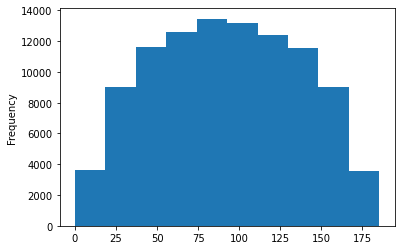

In [8]:
df_0['product'].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

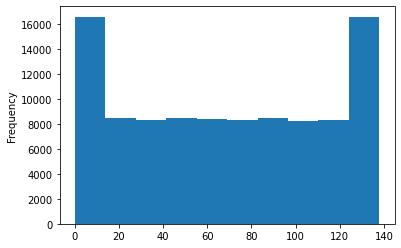

In [9]:
df_1['product'].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

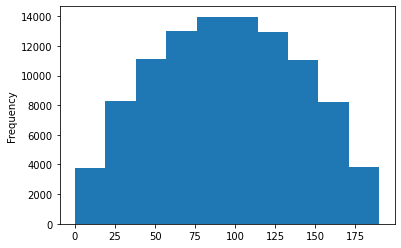

In [10]:
df_2['product'].plot(kind="hist")

В регионе #1 оказалось 8235 нулевых значений (т.е. около 8.235%). Это говорит нам о том, что:
- либо объемы по этим скважинам уже истощены;
- либо их объемы не были измерены корректно и были заполнены нулями.

Помимо этого, у нас также есть большое кол-во скважин с максимальным кол-вом баррелей в них.
Поскольку мы не знаем наверняка, в чем причина, оставим все как есть.

Данные по региону #0 и #2 выглядят хорошо и их распределения целевого признака похожи на нормальные.

## Обучение и проверка модели

Выделим признаки *features* и целевой признак *target*, а затем разделим исходные данные на обучающую и валидационную выборки в соотношении 75:25. А также выделим признаки и целевой признак для каждой выборки. Для этого создадим функцию **data_split**, и затем применим к каждому региону.

In [11]:
def data_split(df, target):
    features = df.drop([target], axis=1)
    target = df[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = data_split(df_0, 'product')
features_train_1, features_valid_1, target_train_1, target_valid_1 = data_split(df_1, 'product')
features_train_2, features_valid_2, target_train_2, target_valid_2 = data_split(df_2, 'product')

In [13]:
print('Размер тренировочной выборки региона #0:', features_train_0.shape[0])
print('Размер валидационной выборки региона #0:', features_valid_0.shape[0])

Размер тренировочной выборки региона #0: 75000
Размер валидационной выборки региона #0: 25000


Проведем маштабирование признаков с помощью метода *StandardScaler*. Для этого создадим функцию **features_scaled** и применим ко всем признакам каждой выборки.

In [14]:
def features_scaled(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    train = scaler.transform(features_train)
    valid = scaler.transform(features_valid)
    return train, valid

In [15]:
features_train_0, features_valid_0 = features_scaled(features_train_0, features_valid_0)
features_train_1, features_valid_1 = features_scaled(features_train_1, features_valid_1)
features_train_2, features_valid_2 = features_scaled(features_train_2, features_valid_2)

Обучим три модели ***линейной регрессии***, сделаем необходимые предсказания. Затем узнаем средний запас предсказанного сырья и RMSE каждой модели. Для этого снова создадим функцию, назовем ее **linearregression_mse** и применим к каждому региону.

In [16]:
def linearregression_mse(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predictions))**0.5
    return predictions, rmse

In [17]:
predictions_0, rmse_0 = linearregression_mse(features_train_0, features_valid_0, target_train_0, target_valid_0)
print(f'Средний запас предсказанного сырья для региона #0: {predictions_0.mean()} тысяч баррелей.')
print(f'RMSE модели для региона #0: {rmse_0}')

Средний запас предсказанного сырья для региона #0: 92.59256778438035 тысяч баррелей.
RMSE модели для региона #0: 37.5794217150813


In [18]:
predictions_1, rmse_1 = linearregression_mse(features_train_1, features_valid_1, target_train_1, target_valid_1)
print(f'Средний запас предсказанного сырья для региона #1: {predictions_1.mean()} тысяч баррелей.')
print(f'RMSE модели для региона #1: {rmse_1}')

Средний запас предсказанного сырья для региона #1: 68.728546895446 тысяч баррелей.
RMSE модели для региона #1: 0.893099286775617


In [19]:
predictions_2, rmse_2 = linearregression_mse(features_train_2, features_valid_2, target_train_2, target_valid_2)
print(f'Средний запас предсказанного сырья для региона #2: {predictions_2.mean()} тысяч баррелей.')
print(f'RMSE модели для региона #2: {rmse_2}')

Средний запас предсказанного сырья для региона #2: 94.96504596800489 тысяч баррелей.
RMSE модели для региона #2: 40.02970873393434


**Вывод:**

Мы получили хороший результат RMSE моделей для региона #1, RMSE модели для региона #1 ниже всех и получилась 0.8931. Однако, средний запас предсказанного сырья для региона #1 также ниже, чем в остальных регионах, и составил 68.73 тысяч баррелей. Скорее всего, это связано с тем, что, как мы выяснили ранее, в регионе #1 около 8,235% данных с нулевым значением по целевому признаку.

## Подготовка к расчёту прибыли

Еще раз повторим условия задачи:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Введем новые переменные.

In [20]:
POINTS = 500
BEST_POINTS = 200
BUDGET = 10**10
INCOME_PER_POINT = 450000

Рассчитаем, сколько баррелей в среднем необходимо добыть для безубыточной разработки новой скважины.

In [21]:
average_income = (BUDGET/BEST_POINTS)/INCOME_PER_POINT
print(f'Достаточный объём сырья для безубыточной разработки новой скважины составляет {average_income} тыс баррелей.')

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.11111111111111 тыс баррелей.


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [22]:
print('Средний запас нефти на скважину в регионе #0', df_0['product'].mean())
print('Средний запас нефти на скважину в регионе #1', df_1['product'].mean())
print('Средний запас нефти на скважину в регионе #2', df_2['product'].mean())

Средний запас нефти на скважину в регионе #0 92.50000000000001
Средний запас нефти на скважину в регионе #1 68.82500000000002
Средний запас нефти на скважину в регионе #2 95.00000000000004


**Вывод:**

Пока однозначный вывод сделать мы не можем, однако, судя по среднему запасу нефти на скважину в каждом регионе, наибольшая вероятность прибольности есть у регионов #2 и #0.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний (топ-200). 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

Перед этим переведем все наши предсказания в pd.Series и сбросим индексы целевого признака в валидационной выборке для каждого региона.

In [23]:
predictions_0 = pd.Series(predictions_0)
predictions_1 = pd.Series(predictions_1)
predictions_2 = pd.Series(predictions_2)

target_valid_0.reset_index(drop=True, inplace=True)
target_valid_1.reset_index(drop=True, inplace=True)
target_valid_2.reset_index(drop=True, inplace=True)

Пишем функцию.

In [24]:
def revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:200]
    profit = (INCOME_PER_POINT * selected.sum()) - BUDGET
    return profit

Прибыль с 200 лучших скважин в регионе #0 (млрд руб):

In [25]:
revenue(target_valid_0, predictions_0) / 10**9

3.3208260431398506

Прибыль с 200 лучших скважин в регионе #1 (млрд руб):

In [26]:
revenue(target_valid_1, predictions_1) / 10**9

2.4150866966815108

Прибыль с 200 лучших скважин в регионе #2 (млрд руб):

In [27]:
revenue(target_valid_2, predictions_2) / 10**9

2.7103499635998327

Посчитаем риски и прибыль для каждого региона. Для этого применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [28]:
state = np.random.RandomState(12345)

def bootstrap_revenue(target, probabilities):
    values = []
    loss = 0
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        profit = revenue(target_subsample, probs_subsample)
        if profit < 0:
            loss += 1
        values.append(profit) 

    values = pd.Series(values)
    
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss_risk = loss / len(values) * 100

    return mean, lower, upper, loss_risk

Результаты для региона #0:

In [29]:
mean_0, lower_0, upper_0, loss_risk_0 = bootstrap_revenue(target_valid_0, predictions_0)

print(f'Средняя прибыль {round(mean_0, 2)} руб.')
print(f'95%-й доверительный интервал {round(lower_0, 2)} - {round(upper_0, 2)} руб.')
print(f'Риск убытков {loss_risk_0} %')

Средняя прибыль 425938526.91 руб.
95%-й доверительный интервал -102090094.84 - 947976353.36 руб.
Риск убытков 6.0 %


Результаты для региона #1:

In [30]:
mean_1, lower_1, upper_1, loss_risk_1 = bootstrap_revenue(target_valid_1, predictions_1)

print(f'Средняя прибыль {round(mean_1, 2)} руб.')
print(f'95%-й доверительный интервал {round(lower_1, 2)} - {round(upper_1, 2)} руб.')
print(f'Риск убытков {loss_risk_1} %')

Средняя прибыль 518259493.7 руб.
95%-й доверительный интервал 128123231.43 - 953612982.07 руб.
Риск убытков 0.3 %


Результаты для региона #2:

In [31]:
mean_2, lower_2, upper_2, loss_risk_2 = bootstrap_revenue(target_valid_2, predictions_2)

print(f'Средняя прибыль {round(mean_2, 2)} руб.')
print(f'95%-й доверительный интервал {round(lower_2, 2)} - {round(upper_2, 2)} руб.')
print(f'Риск убытков {loss_risk_2} %')

Средняя прибыль 420194005.34 руб.
95%-й доверительный интервал -115852609.16 - 989629939.84 руб.
Риск убытков 6.2 %


**Вывод:**

По полученным данным мы можем сделать вывод о том, что наибольшая прибыль у нас во регионе #1, риск убытков также в этом регионе меньше, чем в остальных. В регионах #0 и #2 у нас высокие риски убытков, а также 95% доверительные интервалы захватывают отрицательный профит.
Соответсвенно, мы можем выбрать регион #1 для для разработки скважин, несмотря на то, что в этом регионе у нас был самый маленький средний запас предсказанного сырья.

## Итоговый вывод ##

В ходе проделланой работы мы:
- Загрузили и подготовили данные для обучения моделей.
- Обучили модели линейной регрессии для каждого региона.
- Вычислили средний запас предсказанного сырья для каждого региона, а также их RMSE.
- Вычислили достаточный объём сырья для безубыточной разработки новой скважины.
- Посчитали риски и прибыль для каждого региона и выяснили, что наилучший регион для разработки скважин это регион №1.